# Testing FineNet


In [ ]:
%pip install cv2
%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install pydot
%pip install graphviz
%pip install keras
%pip install tensorflow
%pip install keras_applications
%pip install scikit-image
%pip install GDAL

In [4]:
import sys,os
sys.path.append(os.path.realpath('../FineNet'))
import FineNet_model

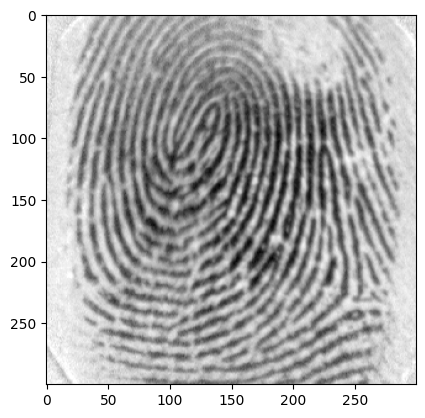

In [8]:
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
  

# Load the TIFF image
image = mpimg.imread("../103_5.tif")

# Display the image
plt.imshow(image, cmap='gray')

In [52]:
from FineNet_model import FineNetmodel, plot_confusion_matrix

import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam
import cv2

os.environ["CUDA_VISIBLE_DEVICES"] = '7'
os.environ['KERAS_BACKEND'] = 'tensorflow'

mnt_refined = []
patch_info = []
patch_size = (55,55)  #patch_size can be changes according to the test sample
stride = 20 
path_to_model = "../FineNet.h5" #path to the pretrained model's checkpoints

model_FineNet = FineNetmodel(num_classes=2,
                             pretrained_path=path_to_model,
                             input_shape=(224,224,3))

model_FineNet.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=0),
                      metrics=['accuracy'])

# Loop through the image to extract patches
for y in range(0, image.shape[0] - patch_size[0] + 1, stride):
    for x in range(0, image.shape[1] - patch_size[1] + 1, stride):

        patch = image[y:y + patch_size[0], x:x + patch_size[1]]
        center_x = x + patch_size[1] // 2
        center_y = y + patch_size[0] // 2

        patch_minu = cv2.resize(patch, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)

        ret = np.empty((patch_minu.shape[0], patch_minu.shape[1], 3), dtype=np.uint8)
        ret[:, :, 0] = patch_minu
        ret[:, :, 1] = patch_minu
        ret[:, :, 2] = patch_minu
        patch_minu = ret
        patch_minu = np.expand_dims(patch_minu, axis=0)

        isMinutiaeProb = model_FineNet.predict(patch_minu)
        isMinutiaeProb = isMinutiaeProb[0]

        mnt_refined.append(isMinutiaeProb)
        patch_info.append(((center_x, center_y), isMinutiaeProb))



Loading FineNet weights from C:/Users/Hager/Downloads/Biometrics/FineNet.h5
1/1 [==============================] - 1s 517ms/step


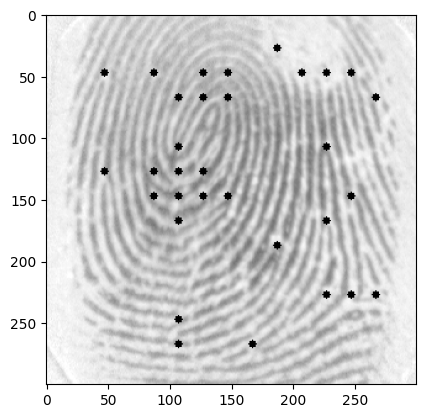

In [53]:
threshold = 0.5  # Adjust this threshold 

image_with_minutiae = image.copy()

# Loop through the patches in patch_info
for (center_x, center_y), isMinutiaeProb in patch_info:
    if isMinutiaeProb[0] > threshold:
        # Draw a dot (circle) at the center of the patch
        cv2.circle(image_with_minutiae, (center_x, center_y), 3, (0, 0, 255), -1)  # Draw a red dot

# Display the image with minutiae
plt.imshow(image_with_minutiae,cmap='gray')